# Introduction to GPflux

In this notebook we cover the basics of Deep Gaussian processes (DGPs) <cite data-cite="damianou2013deep"/> with GPflux. We assume that the reader is familiar with the concepts of Gaussian processes and Deep GPs (see <cite data-cite="rasmussen,gpflow2020"/> for an in-depth overview).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.keras.backend.set_floatx("float64")
tf.get_logger().setLevel("INFO")

2021-10-07 10:01:05.311668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2021-10-07 10:01:05.311699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The motorcycle dataset

We are going to model a one-dimensional dataset containing observations from a simulated motorcycle accident, used to test crash helmets \[1\]. The dataset has many interesting properties that we can use to showcase the power of DGPs as opposed to shallow (that is, single layer) GP models.

Text(0, 0.5, 'Acceleration')

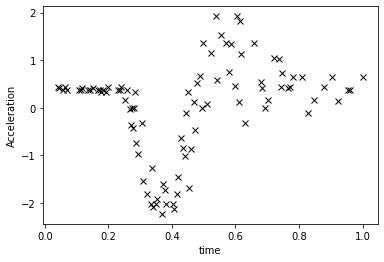

In [2]:
def motorcycle_data():
    """ Return inputs and outputs for the motorcycle dataset. We normalise the outputs. """
    df = pd.read_csv("./data/motor.csv", index_col=0)
    X, Y = df["times"].values.reshape(-1, 1), df["accel"].values.reshape(-1, 1)
    Y = (Y - Y.mean()) / Y.std()
    X /= X.max()
    return X, Y


X, Y = motorcycle_data()
plt.plot(X, Y, "kx")
plt.xlabel("time")
plt.ylabel("Acceleration")

## Single-layer GP

We start this introduction by building a single-layer GP using GPflux. However, you'll notice that we rely a lot on [GPflow](www.github.com/GPflow/GPflow) objects to build our GPflux model. This is a conscious decision. GPflow contains well-tested and stable implementations of key GP building blocks, such as kernels, likelihoods, inducing variables, mean functions, and so on. By relying on GPflow for these elements, we can keep the GPflux code lean and focused on what is important for building deep GP models.  

We are going to build a Sparse Variational Gaussian process (SVGP), for which we refer to <cite data-cite="gpflow2020"/> or <cite data-cite="leibfried2020tutorial"/> for an in-depth overview.

We start by importing `gpflow` and `gpflux`, and then create a kernel and inducing variable. Both are GPflow objects. We pass both objects to a `GPLayer` which will represent a single GP layer in our deep GP. We also need to specify the total number of datapoints and the number of outputs.

In [3]:
import gpflow
import gpflux

num_data = len(X)
num_inducing = 10
output_dim = Y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(X.min(), X.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

2021-10-07 10:01:06.771218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2021-10-07 10:01:06.771248: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-07 10:01:06.771266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az93-857): /proc/driver/nvidia/version does not exist
2021-10-07 10:01:06.771651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/runner/work/GPflux/GPflux/gpflux/lay

We now create a `LikelihoodLayer` which encapsulates a `Likelihood` from GPflow. The likelihood layer is responsible for computing the variational expectation in the objective, and for dealing with our likelihood distribution $p(y | f)$. Other typical likelihoods are `Softmax`, `RobustMax`, and `Bernoulli`. Because we are dealing with the simple case of regression in this notebook, we use the `Gaussian` likelihood.

In [4]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  """Entry point for launching an IPython kernel.


We now pass our GP layer and likelihood layer into a GPflux `DeepGP` model. The `DeepGP` class is a specialisation of the Keras `Model` where we've added a few helper methods such as `predict_f`, `predict_y`, and `elbo`. By relying on Keras, we hope that  users will have an easy time familiarising themselves with the GPflux API. Our `DeepGP` model has the same public API calls: `fit`, `predict`, `evaluate`, and so on.

In [5]:
single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)
model = single_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-10-07 10:01:07.185663: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We train the model by calling `fit`. Keras handles minibatching the data, and keeps track of our loss during training.

2021-10-07 10:01:07.494322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-07 10:01:07.494665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2593905000 Hz


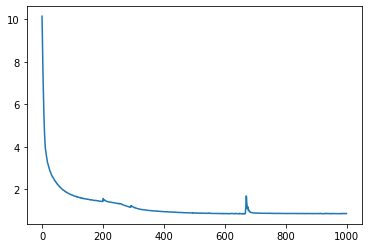

In [6]:
history = model.fit({"inputs": X, "targets": Y}, epochs=int(1e3), verbose=0)
plt.plot(history.history["loss"])

We can now visualise the fit. We clearly see that a single layer GP with a simple stationary kernel has trouble fitting this dataset.

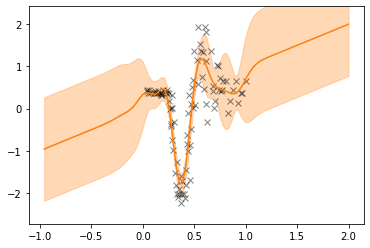

In [7]:
def plot(model, X, Y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    a = 1.0
    N_test = 100
    X_test = np.linspace(X.min() - a, X.max() + a, N_test).reshape(-1, 1)
    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 2 * np.sqrt(var)
    upper = mu + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.5, Y.max() + 0.5)
    ax.plot(X, Y, "kx", alpha=0.5)
    ax.plot(X_test, mu, "C1")

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)


plot(single_layer_dgp.as_prediction_model(), X, Y)

## Two-layer deep Gaussian process

We repeat the exercise but now we build a two-layer model. The setup is very similar apart from the fact that we create two GP layers, and pass them to our `DeepGP` model as a list.
We refer to <cite data-cite="salimbeni2017doubly"/> for details on the deep GP model and variational stochastic inference method.

In [8]:
Z = np.linspace(X.min(), X.max(), num_inducing).reshape(-1, 1)
kernel1 = gpflow.kernels.SquaredExponential()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(
    kernel1, inducing_variable1, num_data=num_data, num_latent_gps=output_dim
)

kernel2 = gpflow.kernels.SquaredExponential()
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=num_data,
    num_latent_gps=output_dim,
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)
model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

/home/runner/work/GPflux/GPflux/gpflux/layers/gp_layer.py:176: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  "Beware, no mean function was specified in the construction of the `GPLayer` "
/home/runner/work/GPflux/GPflux/gpflux/layers/gp_layer.py:199: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  "Could not verify the compatibility of the `kernel`, `inducing_variable` "
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call t

In [9]:
history = model.fit({"inputs": X, "targets": Y}, epochs=int(1e3), verbose=0)

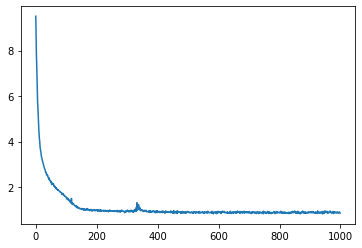

In [10]:
plt.plot(history.history["loss"])

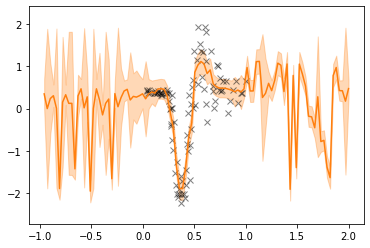

In [11]:
plot(two_layer_dgp.as_prediction_model(), X, Y)

From visual inspection we immediately notice that the two-layer model performs much better.

## References

[1] Silverman, B. W. (1985) "Some aspects of the spline smoothing approach to non-parametric curve fitting". _Journal of the Royal Statistical Society_ series B 47, 1-52.